In [1]:
import os
import glob
import re
import ants

import numpy as np
import pandas as pd

from collections import Counter

raw_data_path = "/Human2/ImageImputation/Data/EBDS/"
processed_data_path = "/BEE/Connectome/Users/amahmood/braintyp/processed_v2/"

In [2]:
# %ls /DATA/Users/amahmood/braintyp/processed_v2/ | grep HCP

In [3]:
# dirs = glob.glob(f"{raw_data_path}/*/*")
# ages = [p.split("/")[-1] for p in dirs]
# Counter(ages)

## After WM Segmentations

In [4]:
save_dir = "/DATA/Users/amahmood/braintyp/segs/"
seg_paths = glob.glob(f"{save_dir}/EBDS*.npz")
len(seg_paths), seg_paths[0]

(118, '/DATA/Users/amahmood/braintyp/segs/EBDS_C0038-1-1.npz')

In [5]:
%%time
t1_wm = []
t2_wm = []

for p in seg_paths:
    with np.load(p) as f:
        t1_wm.append(f['t1'])
        t2_wm.append(f['t2'])

CPU times: user 1.78 s, sys: 124 ms, total: 1.9 s
Wall time: 2.05 s


In [6]:
subids = [re.search(r"(EBDS.*)\.npz", p).group(1) for p in seg_paths]

In [7]:
t1_wm_means = pd.Series(np.array([x.mean() for x in t1_wm]), index=subids)
t2_wm_means = pd.Series(np.array([x.mean() for x in t2_wm]), index=subids)

/tmp/ipykernel_1873966/3350643476.py:1: RuntimeWarning: Mean of empty slice.
  t1_wm_means = pd.Series(np.array([x.mean() for x in t1_wm]), index=subids)
/home/amahmood/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1873966/3350643476.py:2: RuntimeWarning: Mean of empty slice.
  t2_wm_means = pd.Series(np.array([x.mean() for x in t2_wm]), index=subids)


In [8]:
t1_wm_stds = pd.Series(np.array([x.std() for x in t1_wm]), index=subids)
t2_wm_stds = pd.Series(np.array([x.std() for x in t2_wm]), index=subids)

/home/amahmood/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/amahmood/.local/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/amahmood/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.860 w/ std 0.037


In [10]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.051 w/ std 0.010


In [11]:
mult = 3
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

1

In [12]:
t1_wm_means[t1_outliers], t1_wm_stds[t1_outliers]

/tmp/ipykernel_1873966/120456350.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t1_wm_means[t1_outliers], t1_wm_stds[t1_outliers]


(EBDSC0394-1-1    0.746556
 dtype: float32,
 EBDSC0394-1-1    0.036459
 dtype: float32)

In [13]:
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

118

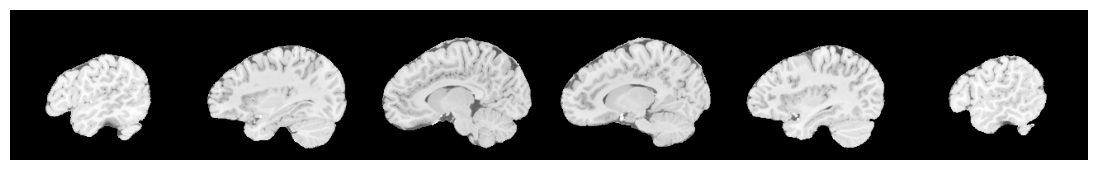

In [ ]:
for tidx in t1_outliers:
    sid = t1_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
#     print(f"{sid}: {path}")
    preproc_path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"

#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd,_ = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6)

### T2

In [ ]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [ ]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.575 w/ std 0.053


In [ ]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.056 w/ std 0.012


In [ ]:
mult = 3.5
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

3

In [ ]:
t2_wm_means[t2_outliers]

/tmp/ipykernel_1873966/383867276.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t2_wm_means[t2_outliers]


EBDSC0235-1-1    0.781935
EBDSC0279-1-1    0.806115
EBDSC0107-2-1    0.775707
dtype: float32

In [ ]:
t2_wm_stds[t2_outliers]

/tmp/ipykernel_1873966/3015510772.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t2_wm_stds[t2_outliers]


EBDSC0235-1-1    0.033507
EBDSC0279-1-1    0.037209
EBDSC0107-2-1    0.041928
dtype: float32

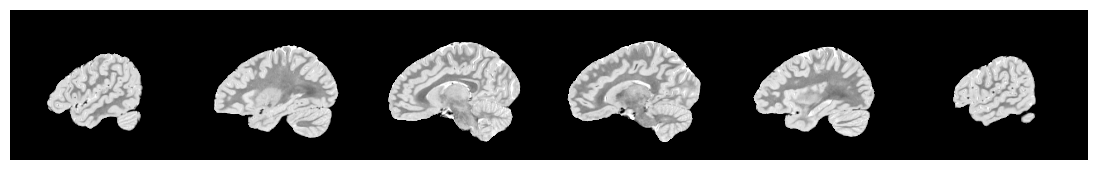

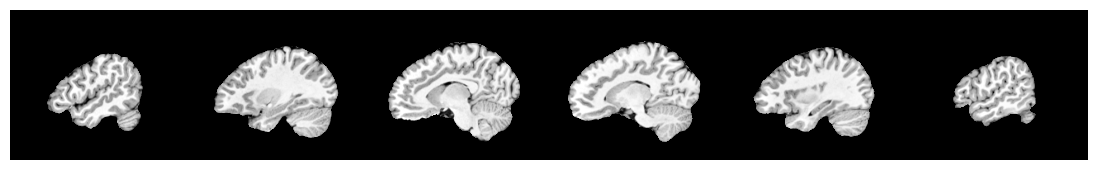

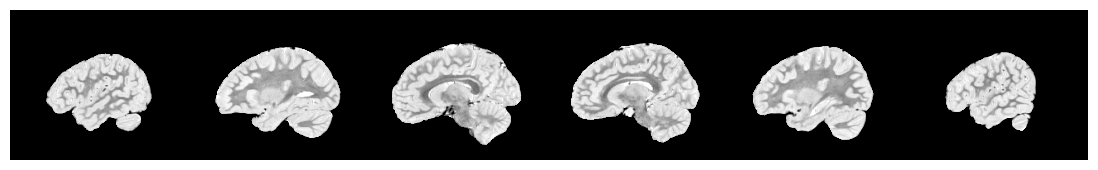

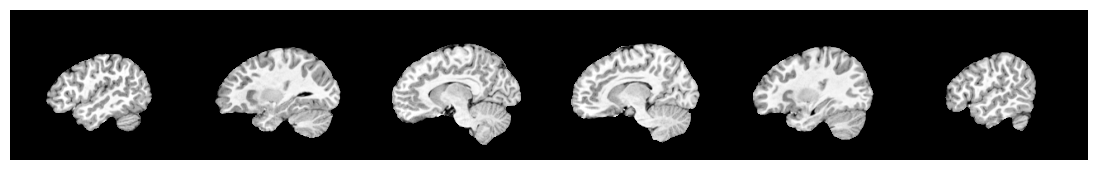

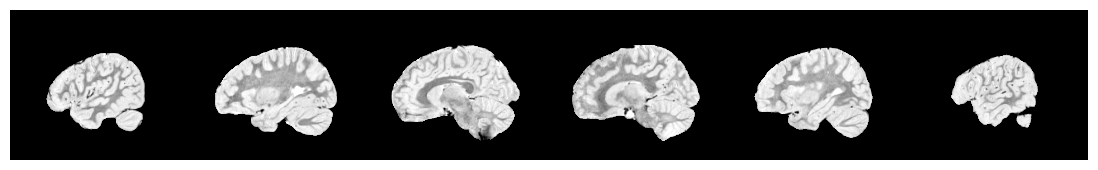

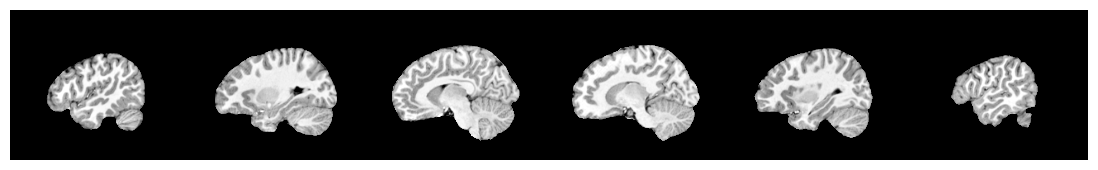

In [21]:
for tidx in t2_outliers:
    sid = t2_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
#     print(f"{sid}: {path}")
    preproc_path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"

#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))

### None of the outliers seem to be QC/acquistion failures. Mostly fat artifacts is my guess

In [22]:
ebds_qc_passing_keys = set(t1_wm_means.dropna().index)
print(f"QC Passing: {len(ebds_qc_passing_keys)}")
ebds_passing_keys = set(pd.read_csv("ebds_brief_basc_passing_keys.txt", header=None)[0])
ebds_passing_keys = ebds_passing_keys.intersection(ebds_qc_passing_keys)
print(f"Remaining: {len(ebds_passing_keys)} - Dropped {len(ebds_qc_passing_keys) - len(ebds_passing_keys)} using BRIEF/BASC")

QC Passing: 117
Remaining: 93 - Dropped 24 using BRIEF/BASC


In [23]:
ebds_passing_keys = pd.Series(list(ebds_passing_keys))
ebds_passing_keys.to_csv('../split-keys/ebds_keys.txt', header=None, index=None)